In [1]:
import pandas as pd

df = pd.read_csv('data/DATASET_ic50_cleaned_compounds.csv')

In [2]:
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold

# Generate Murcko scaffolds for each molecule
def get_murcko_scaffold(smiles):
    """Extract Murcko scaffold from SMILES string."""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        scaffold = MurckoScaffold.GetScaffoldForMol(mol)
        return Chem.MolToSmiles(scaffold)
    except:
        return None

# Apply scaffold generation
print("Generating Murcko scaffolds...")
df['scaffold'] = df['smiles'].apply(get_murcko_scaffold)

# Filter out compounds where scaffold generation failed
df_valid = df[df['scaffold'].notna()].copy()

print(f"Compounds with valid scaffolds: {len(df_valid):,} / {len(df):,}")
print(f"Failed scaffold generation: {len(df) - len(df_valid):,}")


Generating Murcko scaffolds...
Compounds with valid scaffolds: 422 / 422
Failed scaffold generation: 0


In [3]:
from collections import Counter

# Count compounds per scaffold
scaffold_counts = Counter(df_valid['scaffold'])

print(f"Total unique scaffolds: {len(scaffold_counts):,}")
print(f"\nScaffold distribution:")
print(f"  Singletons (1 compound): {sum(1 for c in scaffold_counts.values() if c == 1):,}")
print(f"  Small series (2-5): {sum(1 for c in scaffold_counts.values() if 2 <= c <= 5):,}")
print(f"  Medium series (6-20): {sum(1 for c in scaffold_counts.values() if 6 <= c <= 20):,}")
print(f"  Large series (>20): {sum(1 for c in scaffold_counts.values() if c > 20):,}")

# Show top 10 most common scaffolds
print(f"\nTop 10 scaffolds by compound count:")
for scaffold, count in scaffold_counts.most_common(10):
    print(f"  {count:4d} compounds: {scaffold[:50]}..." if len(scaffold) > 50 else f"  {count:4d} compounds: {scaffold}")


Total unique scaffolds: 168

Scaffold distribution:
  Singletons (1 compound): 121
  Small series (2-5): 36
  Medium series (6-20): 7
  Large series (>20): 4

Top 10 scaffolds by compound count:
    50 compounds: c1ccc(-c2cc3nc(OCC45CCCN4CCC5)nc(N4CC5CCC(C4)N5)c3...
    49 compounds: c1ccc2c(-c3cc4nc(OCC56CCCN5CCC6)nc(N5CC6CCC(C5)N6)...
    31 compounds: c1ccc2c(-c3cc4ncnc(N5CC6CCC(C5)N6)c4cn3)cccc2c1
    27 compounds: c1ccc2c(-c3cc4nc(OC[C@@H]5CCCN5)nc(N5CC6CCC(C5)N6)...
     9 compounds: c1ccc(C2CC2)c(-c2cc3nc(OCC45CCCN4CCC5)nc(N4CC5CCC(...
     8 compounds: O=C1CNC(=O)C(Cc2ccccc2)NC(=O)CNC(=O)C2CCCN2C(=O)CC...
     8 compounds: c1ccc2c(-c3cc4nc(N5CCC5)nc(N5CC6CCC(C5)N6)c4cn3)cc...
     6 compounds: O=C1CNC(=O)C(Cc2ccc(-c3ccccc3)cc2)NC(=O)CNC(=O)C2C...
     6 compounds: c1cncc(CCOc2nc(N3CC4CCC(C3)N4)c3cnc(-c4cccc5ccccc4...
     6 compounds: c1ccc(CCOc2nc(N3CC4CCC(C3)N4)c3cnc(-c4cccc5ccccc45...


In [ ]:
from collections import Counter
import numpy as np
import pandas as pd

def scaffold_ic50_split(df, smiles_col='smiles', target_col='pIC50',
                                test_size=0.2, n_bins=10, random_state=42):
    np.random.seed(random_state)
    
    # Bin pIC50 values
    df['pIC50_bin'] = pd.qcut(df[target_col], q=n_bins, labels=False, duplicates='drop')
    
    # Extract scaffolds
    scaffolds = df[smiles_col].apply(get_murcko_scaffold)
    
    # Group indices by scaffold
    # {Scaffold 1: [1, 4, 5], Scaffold 2: [2, 3, 7] ...}
    scaffold_to_indices = {}
    for idx, scaffold in zip(df.index, scaffolds):
        if scaffold is None:
            scaffold = f'NONE_{idx}'
        scaffold_to_indices.setdefault(scaffold, []).append(idx)
    
    # Compute bin count vectors per scaffold
    # {Scaffold 1: [2, 1, 2, 0, 0], Scaffold 2: [1, 3, 0, 0, 0] ...}
    scaffold_bin_counts = {}
    for scaffold, indices in scaffold_to_indices.items():
        bins = df.loc[indices, 'pIC50_bin']
        counts = bins.value_counts().reindex(range(n_bins), fill_value=0).values
        scaffold_bin_counts[scaffold] = counts
    
    # Initialize splits and bin counts
    splits = {'train': [], 'test': []}
    split_bin_counts = {
        'train': np.zeros(n_bins, dtype=int),
        'test': np.zeros(n_bins, dtype=int)
    }
    split_targets = {
        'train': 1.0 - test_size,
        'test': test_size
    }
    
    n_total = len(df)
    # Overall bin counts across entire dataset
    # [120, 240, 120, 240, 120]
    total_bin_counts = df['pIC50_bin'].value_counts().reindex(range(n_bins), fill_value=0).values

    # Target bin counts for each split proportional to bin frequencies
    # {train: [100,200,100,200,100], test: [20, 40, 20, 40, 20]}
    target_bin_counts = {
        split: split_targets[split] * n_total * (total_bin_counts / total_bin_counts.sum())
        for split in splits
    }
    
    # Sort scaffolds by size (number of molecules)
    sorted_scaffolds = sorted(scaffold_to_indices.keys(),
                              key=lambda s: len(scaffold_to_indices[s]),
                              reverse=True)
    
    # Assign scaffolds greedily to minimize bin distribution error
    for scaffold in sorted_scaffolds:
        sc_counts = scaffold_bin_counts[scaffold]
        
        errors = {}
        for split in splits:
            # Proposed bin counts if scaffold assigned here
            proposed_bin_counts = split_bin_counts[split] + sc_counts
            
            # Calculate sum of absolute differences from target bin counts
            error = np.sum(np.abs(proposed_bin_counts - target_bin_counts[split]))
            
            # Also consider error in other split unchanged
            other_split = 'test' if split == 'train' else 'train'
            other_error = np.sum(np.abs(split_bin_counts[other_split] - target_bin_counts[other_split]))
            
            total_error = error + other_error
            errors[split] = total_error
        
        # Assign scaffold to split with minimal total error
        best_split = min(errors, key=errors.get)
        
        splits[best_split].extend(scaffold_to_indices[scaffold])
        split_bin_counts[best_split] += sc_counts
    
    return splits['train'], splits['test']


In [9]:
import pandas as pd
import matplotlib.pyplot as plt

def analyze_bin_distribution(df, train_idx, test_idx, bin_col='pIC50_bin'):
    train_bins = df.loc[train_idx, bin_col].value_counts().sort_index()
    test_bins = df.loc[test_idx, bin_col].value_counts().sort_index()

    bin_dist = pd.DataFrame({
        'Train': train_bins,
        'Test': test_bins
    }).fillna(0)

    print("pIC50 bin counts per split:")
    print(bin_dist)

    # Normalize to proportions for easier comparison
    bin_dist_norm = bin_dist.div(bin_dist.sum(axis=0), axis=1)
    
    # Plot
    ax = bin_dist_norm.plot(kind='bar', figsize=(8, 5))
    ax.set_title('Normalized pIC50 Bin Distribution by Split')
    ax.set_xlabel('pIC50 Bin')
    ax.set_ylabel('Proportion of molecules')
    plt.xticks(rotation=0)
    plt.show()

    return bin_dist, bin_dist_norm


In [37]:
# Perform scaffold-based split
train_idx, test_idx = scaffold_ic50_split(
    df_valid,
    smiles_col='smiles',
    target_col='pIC50',
    test_size=0.2,
    #val_size=0.1,
    n_bins = 5,
    random_state=42
)

# Create split DataFrames
df_train = df_valid.loc[train_idx].copy()
#df_val = df_valid.loc[val_idx].copy()
df_test = df_valid.loc[test_idx].copy()

print(f"Scaffold-based split:")
print(f"  Train: {len(df_train):,} compounds ({100*len(df_train)/len(df_valid):.1f}%)")
#print(f"  Val:   {len(df_val):,} compounds ({100*len(df_val)/len(df_valid):.1f}%)")
print(f"  Test:  {len(df_test):,} compounds ({100*len(df_test)/len(df_valid):.1f}%)")


Scaffold-based split:
  Train: 337 compounds (79.9%)
  Test:  85 compounds (20.1%)


pIC50 bin counts per split:
           Train  Test
pIC50_bin             
0             68    17
1             67    17
2             67    17
3             67    17
4             68    17


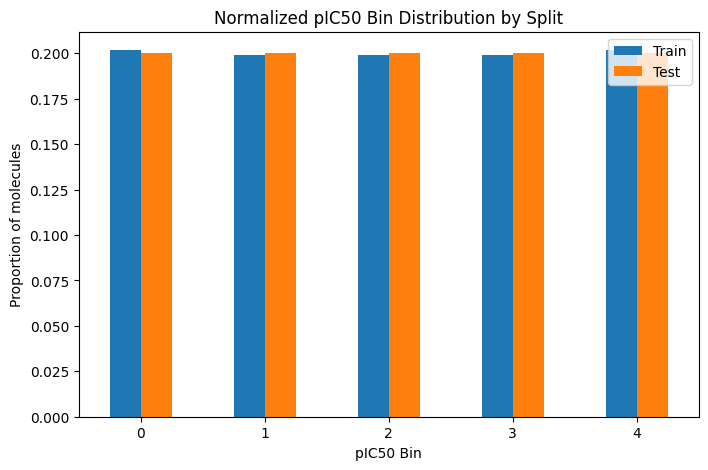

In [38]:
bin_counts, bin_props = analyze_bin_distribution(df_valid, train_idx, test_idx)

In [39]:
import matplotlib.pyplot as plt

def plot_scaffold_split_sizes(summary_df):
    summary_df_sorted = summary_df.sort_values('Total', ascending=False)
    summary_df_sorted[['Train', 'Test']].plot(kind='bar', stacked=True, figsize=(12,6))
    plt.xticks([])  # Hide x-axis labels
    plt.xlabel('Scaffolds (hidden)')
    plt.ylabel('Number of Molecules')
    plt.title('Molecule Counts per Scaffold by Split')
    plt.show()


In [40]:
import pandas as pd

def summarize_scaffold_split(df, train_idx, test_idx, smiles_col='smiles'):
    # Extract scaffolds
    scaffolds = df[smiles_col].apply(get_murcko_scaffold)
    df = df.copy()
    df['scaffold'] = scaffolds
    
    # Assign split label
    df['split'] = 'None'
    df.loc[train_idx, 'split'] = 'Train'
    df.loc[test_idx, 'split'] = 'Test'
    
    # Group by scaffold and split
    summary = df.groupby(['scaffold', 'split']).size().unstack(fill_value=0)
    
    # Add total per scaffold
    summary['Total'] = summary.sum(axis=1)
    return summary


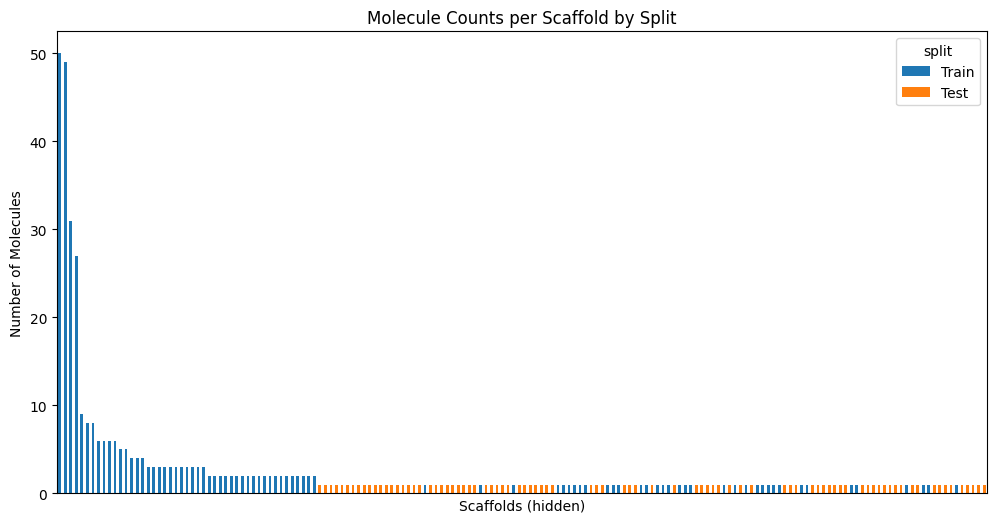

In [41]:
summary_df = summarize_scaffold_split(df, train_idx, test_idx)
plot_scaffold_split_sizes(summary_df)

In [43]:
# Verify zero scaffold overlap
train_scaffolds = set(df_train['scaffold'])
#val_scaffolds = set(df_val['scaffold'])
test_scaffolds = set(df_test['scaffold'])

#train_val_overlap = train_scaffolds.intersection(val_scaffolds)
train_test_overlap = train_scaffolds.intersection(test_scaffolds)
#val_test_overlap = val_scaffolds.intersection(test_scaffolds)

print("Scaffold Overlap Verification:")
#print(f"  Train-Val overlap: {len(train_val_overlap)} scaffolds")
print(f"  Train-Test overlap: {len(train_test_overlap)} scaffolds")
#print(f"  Val-Test overlap: {len(val_test_overlap)} scaffolds")

if len(train_test_overlap) == 0:
    print("\n[SUCCESS] Zero scaffold overlap - split integrity verified!")
else:
    print("\n[ERROR] Scaffold overlap detected - check implementation!")


Scaffold Overlap Verification:
  Train-Test overlap: 0 scaffolds

[SUCCESS] Zero scaffold overlap - split integrity verified!


In [44]:
# Analyze pIC50 distributions across splits
print("pIC50 Distribution Analysis:")
print(f"{'Partition':<10} {'Count':>8} {'Mean':>8} {'Std':>8} {'Min':>8} {'Max':>8}")
print("-" * 58)

for name, data in [('Train', df_train), ('Test', df_test)]:
    print(f"{name:<10} {len(data):>8,} {data['pIC50'].mean():>8.2f} {data['pIC50'].std():>8.2f} {data['pIC50'].min():>8.2f} {data['pIC50'].max():>8.2f}")

print("-" * 58)
print(f"{'Total':<10} {len(df_valid):>8,} {df_valid['pIC50'].mean():>8.2f} {df_valid['pIC50'].std():>8.2f} {df_valid['pIC50'].min():>8.2f} {df_valid['pIC50'].max():>8.2f}")


pIC50 Distribution Analysis:
Partition     Count     Mean      Std      Min      Max
----------------------------------------------------------
Train           337     6.57     1.18     4.41     9.70
Test             85     6.57     1.13     4.69     9.00
----------------------------------------------------------
Total           422     6.57     1.17     4.41     9.70


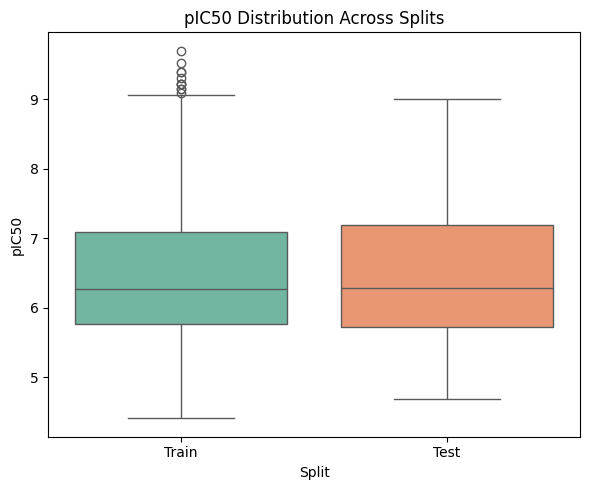

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Combine data with labels
df_train['Split'] = 'Train'
#df_val['Split'] = 'Val'
df_test['Split'] = 'Test'
df_combined = pd.concat([df_train, df_test])

# Box plot
plt.figure(figsize=(6, 5))
sns.boxplot(data=df_combined, x='Split', y='pIC50', hue='Split',
            order=['Train', 'Test'], palette='Set2', legend=False)
plt.title('pIC50 Distribution Across Splits')
plt.tight_layout()
plt.show()


In [47]:
# Create index mapping from SMILES to row position

df_ecfp4_final = pd.read_csv("data/DATASET_ecfp4.csv")
df_maccs_final = pd.read_csv("data/DATASET_maccs.csv")
df_rdkit_final = pd.read_csv("data/DATASET_rdkit.csv")
df_fingerprints_combined = pd.read_csv("data/DATASET_fp_combined.csv")

smiles_to_split = {}
for idx in train_idx:
    smiles_to_split[df_valid.loc[idx, 'smiles']] = 'train'
#for idx in val_idx:
#    smiles_to_split[df_valid.loc[idx, 'smiles']] = 'val'
for idx in test_idx:
    smiles_to_split[df_valid.loc[idx, 'smiles']] = 'test'
 
def split_by_smiles(df, smiles_col='smiles'):
    """Split DataFrame using SMILES-based assignment."""
    df['split'] = df[smiles_col].map(smiles_to_split)
    train = df[df['split'] == 'train'].drop(columns=['split'])
    #val = df[df['split'] == 'val'].drop(columns=['split'])
    test = df[df['split'] == 'test'].drop(columns=['split'])
    return train, test
 
# Split all fingerprint datasets
fp_ecfp4_train, fp_ecfp4_test = split_by_smiles(df_ecfp4_final)
fp_maccs_train, fp_maccs_test = split_by_smiles(df_maccs_final)
fp_rdkit_train, fp_rdkit_test = split_by_smiles(df_rdkit_final)
fp_combined_train, fp_combined_test = split_by_smiles(df_fingerprints_combined)
 
print(f"ECFP4 split: train={len(fp_ecfp4_train)}, test={len(fp_ecfp4_test)}")
print(f"MACCS split: train={len(fp_maccs_train)}, test={len(fp_maccs_test)}")
print(f"RDKIT split: train={len(fp_rdkit_train)}, test={len(fp_rdkit_test)}")
print(f"Combined FP split: train={len(fp_combined_train)}, test={len(fp_combined_test)}")

ECFP4 split: train=337, test=85
MACCS split: train=337, test=85
RDKIT split: train=337, test=85
Combined FP split: train=337, test=85


In [48]:
# Split descriptor dataset
df_descriptors_rdkit = pd.read_csv("data/DATASET_descriptors_rdkit.csv")
desc_train_rdkit, desc_test_rdkit = split_by_smiles(df_descriptors_rdkit)
print(f"RDKit Descriptor split: train={len(desc_train_rdkit)}, test={len(desc_test_rdkit)}")

df_descriptors_mordred = pd.read_csv("data/DATASET_descriptors_mordred.csv")
desc_train_mordred, desc_test_mordred = split_by_smiles(df_descriptors_mordred)
print(f"Mordred Descriptor split: train={len(desc_train_mordred)}, test={len(desc_test_mordred)}")

RDKit Descriptor split: train=337, test=85
Mordred Descriptor split: train=337, test=85


In [49]:
import os

# Create splits directory
os.makedirs('splits', exist_ok=True)

# Save ECFP4 splits
fp_ecfp4_train.to_csv('splits/DATASET_ecfp4_train.csv', index=False)
#fp_ecfp4_val.to_csv('splits/DATASET_ecfp4_val.csv', index=False)
fp_ecfp4_test.to_csv('splits/DATASET_ecfp4_test.csv', index=False)

# Save MACCS splits
fp_maccs_train.to_csv('splits/DATASET_maccs_train.csv', index=False)
#fp_maccs_val.to_csv('splits/DATASET_maccs_val.csv', index=False)
fp_maccs_test.to_csv('splits/DATASET_maccs_test.csv', index=False)

# Save RDKit fingerprint splits
fp_rdkit_train.to_csv('splits/DATASET_rdkit_fp_train.csv', index=False)
#fp_rdkit_val.to_csv('splits/DATASET_rdkit_fp_val.csv', index=False)
fp_rdkit_test.to_csv('splits/DATASET_rdkit_fp_test.csv', index=False)

# Save combined fingerprint splits
fp_combined_train.to_csv('splits/DATASET_fingerprints_combined_train.csv', index=False)
#fp_combined_val.to_csv('splits/DATASET_fingerprints_combined_val.csv', index=False)
fp_combined_test.to_csv('splits/DATASET_fingerprints_combined_test.csv', index=False)

# Save descriptor splits
desc_train_rdkit.to_csv('splits/DATASET_descriptors_rdkit_train.csv', index=False)
#desc_val.to_csv('splits/DATASET_descriptors_val.csv', index=False)
desc_test_rdkit.to_csv('splits/DATASET_descriptors_rdkit_test.csv', index=False)

desc_train_mordred.to_csv('splits/DATASET_descriptors_mordred_train.csv', index=False)
#desc_val.to_csv('splits/DATASET_descriptors_val.csv', index=False)
desc_test_mordred.to_csv('splits/DATASET_descriptors_mordred_test.csv', index=False)

print("All split datasets saved to 'splits/' directory")
print(f"Files created: {len(os.listdir('splits'))}")


All split datasets saved to 'splits/' directory
Files created: 23



ECFP4:
  Feature columns: 2048
  Excluded columns: ['molecule_chembl_id', 'smiles', 'pIC50']
  Train: 337, Test: 85

MACCS:
  Feature columns: 167
  Excluded columns: ['molecule_chembl_id', 'smiles', 'pIC50']
  Train: 337, Test: 85

RDKit Fingerprints:
  Feature columns: 2048
  Excluded columns: ['molecule_chembl_id', 'smiles', 'pIC50']
  Train: 337, Test: 85

Combined Fingerprints:
  Feature columns: 4263
  Excluded columns: ['molecule_chembl_id', 'smiles', 'pIC50']
  Train: 337, Test: 85

RDKit Descriptors:
  Feature columns: 89
  Excluded columns: ['molecule_chembl_id', 'smiles', 'pIC50']
  Train: 337, Test: 85

Mordred Descriptors:
  Feature columns: 374
  Excluded columns: ['molecule_chembl_id', 'smiles', 'pIC50']
  Train: 337, Test: 85


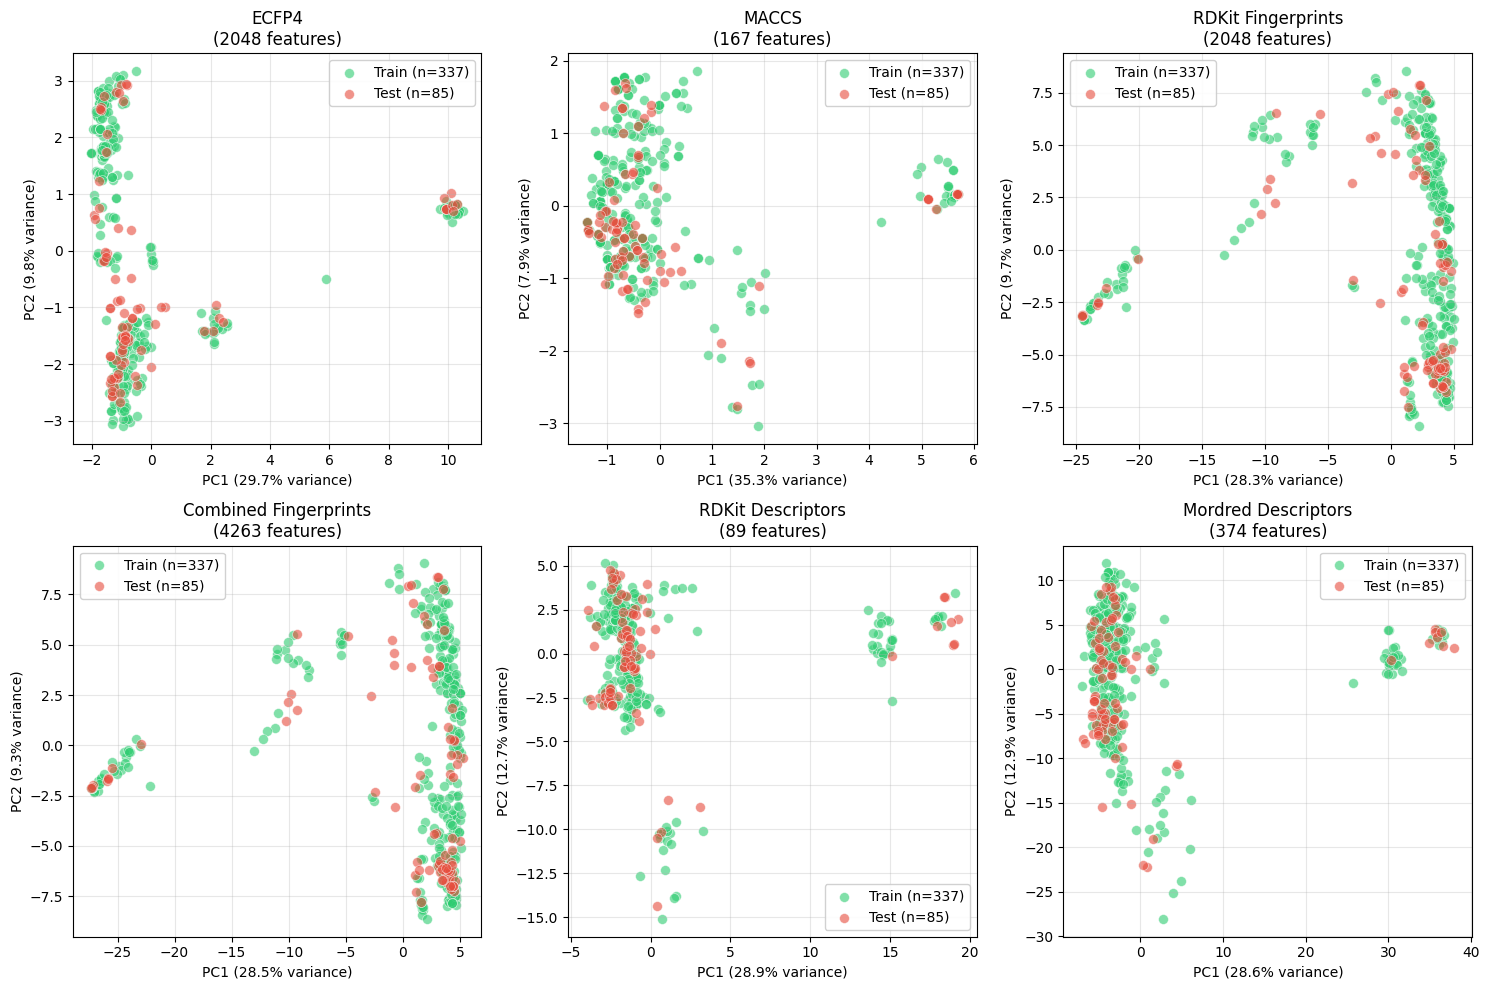

In [60]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Define the 5 methods and their file prefixes
methods = {
    'ECFP4': 'DATASET_ecfp4',
    'MACCS': 'DATASET_maccs',
    'RDKit Fingerprints': 'DATASET_rdkit_fp',
    'Combined Fingerprints': 'DATASET_fingerprints_combined',
    'RDKit Descriptors': 'DATASET_descriptors_rdkit',
    'Mordred Descriptors': 'DATASET_descriptors_mordred'
}

# Columns to exclude (non-feature columns)
EXCLUDE_COLS = ['molecule_chembl_id', 'smiles', 'pIC50']

def detect_feature_columns(df):
    """
    Detect feature columns by excluding specified non-feature columns.
    """
    non_feature_cols = [col for col in df.columns if col in EXCLUDE_COLS]
    feature_cols = [col for col in df.columns if col not in EXCLUDE_COLS]
    return feature_cols, non_feature_cols

def load_splits(file_prefix, splits_dir='splits'):
    """
    Load train, validation, and test splits for a given method.
    """
    train_df = pd.read_csv(f'{splits_dir}/{file_prefix}_train.csv')
    #val_df = pd.read_csv(f'{splits_dir}/{file_prefix}_val.csv')
    test_df = pd.read_csv(f'{splits_dir}/{file_prefix}_test.csv')
    return train_df, test_df

def plot_pca_for_method(method_name, file_prefix, splits_dir='splits', ax=None):
    """
    Perform PCA and plot for train/val/test subsets of a given method.
    """
    # Load data
    train_df, test_df = load_splits(file_prefix, splits_dir)

    # Detect feature columns
    feature_cols, non_feature_cols = detect_feature_columns(train_df)

    print(f"\n{method_name}:")
    print(f"  Feature columns: {len(feature_cols)}")
    print(f"  Excluded columns: {non_feature_cols}")
    print(f"  Train: {len(train_df)}, Test: {len(test_df)}")

    # Extract features
    X_train = train_df[feature_cols].values.astype(float)
    #X_val = val_df[feature_cols].values.astype(float)
    X_test = test_df[feature_cols].values.astype(float)

    # Only scale for Descriptors
    if "Descriptors" in method_name:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        #X_val = scaler.transform(X_val)
        X_test = scaler.transform(X_test)

    # Perform PCA (fit on train, transform all)
    pca = PCA(n_components=2)
    train_pca = pca.fit_transform(X_train)
    #val_pca = pca.transform(X_val)
    test_pca = pca.transform(X_test)

    # Get explained variance
    var_explained = pca.explained_variance_ratio_ * 100

    # Plot
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    ax.scatter(train_pca[:, 0], train_pca[:, 1], alpha=0.6, label=f'Train (n={len(train_df)})',
               c='#2ecc71', edgecolors='white', linewidth=0.5, s=50)
    #ax.scatter(val_pca[:, 0], val_pca[:, 1], alpha=0.6, label=f'Val (n={len(val_df)})',
    #           c='#3498db', edgecolors='white', linewidth=0.5, s=50)
    ax.scatter(test_pca[:, 0], test_pca[:, 1], alpha=0.6, label=f'Test (n={len(test_df)})',
               c='#e74c3c', edgecolors='white', linewidth=0.5, s=50)

    ax.set_xlabel(f'PC1 ({var_explained[0]:.1f}% variance)')
    ax.set_ylabel(f'PC2 ({var_explained[1]:.1f}% variance)')
    ax.set_title(f'{method_name}\n({len(feature_cols)} features)')
    ax.legend(loc='best', framealpha=0.9)
    ax.grid(True, alpha=0.3)

    return pca, var_explained

# Main execution
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, (method_name, file_prefix) in enumerate(methods.items()):
    plot_pca_for_method(method_name, file_prefix, splits_dir='splits', ax=axes[idx])

plt.tight_layout()
plt.show()


In [6]:
#feature selection

import pandas as pd
from sklearn.feature_selection import SelectKBest, mutual_info_regression

fp_ecfp4_train = pd.read_csv("splits/DATASET_ecfp4_train.csv")
#fp_ecfp4_val = pd.read_csv("splits/DATASET_ecfp4_val.csv")
fp_ecfp4_test = pd.read_csv("splits/DATASET_ecfp4_test.csv")
fp_maccs_train = pd.read_csv("splits/DATASET_maccs_train.csv")
#fp_maccs_val = pd.read_csv("splits/DATASET_maccs_val.csv")
fp_maccs_test = pd.read_csv("splits/DATASET_maccs_test.csv")
fp_rdkit_train = pd.read_csv("splits/DATASET_rdkit_fp_train.csv")
#fp_rdkit_val = pd.read_csv("splits/DATASET_rdkit_fp_val.csv")
fp_rdkit_test = pd.read_csv("splits/DATASET_rdkit_fp_test.csv")
fp_combined_train = pd.read_csv("splits/DATASET_fingerprints_combined_train.csv")
#fp_combined_val = pd.read_csv("splits/DATASET_fingerprints_combined_val.csv")
fp_combined_test = pd.read_csv("splits/DATASET_fingerprints_combined_test.csv")
desc_rdkit_train = pd.read_csv("splits/DATASET_descriptors_rdkit_train.csv")
#desc_val = pd.read_csv("splits/DATASET_descriptors_val.csv")
desc_rdkit_test = pd.read_csv("splits/DATASET_descriptors_rdkit_test.csv")
desc_mordred_train = pd.read_csv("splits/DATASET_descriptors_mordred_train.csv")
#desc_val = pd.read_csv("splits/DATASET_descriptors_val.csv")
desc_mordred_test = pd.read_csv("splits/DATASET_descriptors_mordred_test.csv")

feature_groups = {
    "ECFP4": (fp_ecfp4_train, fp_ecfp4_test),
    "MACCS": (fp_maccs_train, fp_maccs_test),
    "RDKit": (fp_rdkit_train, fp_rdkit_test),
    "CombinedFP": (fp_combined_train, fp_combined_test),
    "RDKit_Descriptors": (desc_rdkit_train, desc_rdkit_test),
    "Mordred_Descriptors": (desc_mordred_train, desc_mordred_test)
}


In [ ]:
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_regression, SelectFromModel
from sklearn.linear_model import LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import joblib
import numpy as np

# ==============================
# Cross-validation setup
# ==============================

cv = KFold(n_splits=10, shuffle=True, random_state=42)

# ==============================
# Storage
# ==============================

results = {}
target_col = "pIC50"
metadata_cols=['molecule_chembl_id', 'smiles', 'pIC50']

models_dict = {
    "RF": RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1),
    "SVR": SVR(kernel='rbf', C=1.0, epsilon=0.1, gamma='scale'),
    "XGB": XGBRegressor(n_estimators=100,learning_rate=0.1,max_depth=3,subsample=1.0,colsample_bytree=1.0,reg_lambda=0.0,reg_alpha=1.0,objective="reg:squarederror",random_state=42,n_jobs=1),
    "LightGBM": LGBMRegressor(n_estimators=100,learning_rate=0.1,num_leaves=31,random_state=42,n_jobs=1,importance_type='gain', verbose=-1),
}

# ==============================
# Loop over feature groups
# ==============================

for model in models_dict:
    print(f"\n=== Baseline {model} model ===")
    baseline = models_dict[model]

    for name, (train_df, test_df) in feature_groups.items():
        print(f"Running Baseline Model for : {name}")

        feature_cols = [c for c in train_df.columns if c not in metadata_cols]
        X_train = train_df[feature_cols]
        y_train = train_df[target_col]

        # Select data
        if "Descriptors" in name:
            # Feature selection: LASSO-based
            selector = SelectFromModel(LassoCV(cv=cv, max_iter=50000, n_jobs=-1, random_state=42))
        else:  # Descriptors
            # Feature selection: univariate, tuneable k
            selector = SelectKBest(score_func=lambda X, y: mutual_info_regression(X, y, random_state=42), k='all')  # baseline: keep all

        # Convert to numpy for pipelines
        X_np = X_train.values
        y_np = y_train.values

        pipeline = Pipeline([
            ("scaler", StandardScaler()),
            ("feature_selection", selector),
            ("model", baseline)
        ])

        scores = cross_val_score(
            pipeline,
            X_np,
            y_np,
            cv=cv,
            scoring="neg_root_mean_squared_error",
            n_jobs=-1
        )

        y_pred = cross_val_predict(pipeline, X_np, y_np, cv=cv)
        q2 = r2_score(y_np, y_pred)
        mae = mean_absolute_error(y_np, y_pred)
        rmse = np.sqrt(mean_squared_error(y_np, y_pred))
        rmse_mean = -scores.mean()
        rmse_std = scores.std()

        pipeline.fit(X_train, y_train)  # Fit on training data
        train_r2 = pipeline.score(X_train, y_train)  # R² on training data

        metrics = {'R2': train_r2, 'Q2': q2, 'CV RMSE mean': rmse_mean, 'CV RMSE std': rmse_std, 'RMSE': rmse, 'MAE': mae}

        results[f'{model}_{name}_baseline_train'] = metrics

        print(f"{'Train':15} R²={train_r2:.3f}  Q²(10 fold CV)={q2:.3f}  RMSE(10 fold CV)={rmse:.3f}  RMSE (Mean)={rmse_mean:.3f}  RMSE (Std)={rmse_std}  MAE(10 fold CV)={mae:.3f}")

        joblib.dump(baseline, f'models/{model}_{name}_baseline.joblib')        

In [26]:
#save results so no need to rerun next time
df = pd.DataFrame.from_dict(results, orient='index')

# Optional: reset index to make model names a column
df = df.reset_index().rename(columns={'index': 'Model'})

# Save to CSV
df.to_csv("data/model_metrics.csv", index=False)

In [27]:
df = pd.read_csv("data/model_metrics.csv")
df

,Model,R2,Q2,CV RMSE mean,CV RMSE std,RMSE,MAE
0,RF_ECFP4_baseline_train,0.959687,0.712025,0.628191,0.069408,0.631759,0.476740
1,RF_MACCS_baseline_train,0.853043,0.602830,0.735297,0.096716,0.741928,0.555730
2,RF_RDKit_baseline_train,0.957859,0.704544,0.627107,0.127831,0.639912,0.474664
3,RF_CombinedFP_baseline_train,0.960104,0.697433,0.639460,0.104332,0.647566,0.476684
4,RF_RDKit_Descriptors_baseline_train,0.950924,0.645921,0.694533,0.089672,0.700526,0.509063
5,RF_Mordred_Descriptors_baseline_train,0.954610,0.646390,0.687551,0.131339,0.700062,0.522099
6,SVR_ECFP4_baseline_train,0.902743,0.565508,0.769511,0.096180,0.776006,0.596917
7,SVR_MACCS_baseline_train,0.697955,0.500713,0.824991,0.105105,0.831857,0.636058
8,SVR_RDKit_baseline_train,0.862219,0.671394,0.670529,0.074770,0.674857,0.518037
9,SVR_CombinedFP_baseline_train,0.908152,0.650114,0.691359,0.079841,0.696366,0.530957


In [4]:
#reading from saved file (if needed)

import pandas as pd

df = pd.read_csv("data/model_metrics.csv")

# Set Model as index
df = df.set_index("Model")

# Convert back to nested dict
results = df.to_dict(orient="index")

ECFP4 fingerprints performed relatively well for RF, XGB and LightGBM models, while maintaining high stability

As an additional exploration, we will also be looking at combining the better performing fingerprint and descriptor feature groups (ECFP4 fingerprints + RDKit descriptors) to see if performance improves.

Finally, we will be doing a simple MLP model and transfer learning on GNN model to verify performance


In [16]:
import math
from sklearn.model_selection import GridSearchCV

def grid_search_best_performing(model, selector, X_train, y_train):

    if model == "RF":
        # Define the search space
        param_grid = {
            'model__n_estimators': [200, 400],          # Enough trees for stability
            'model__max_depth': [12, 20, None],         # Shallow, medium, unlimited
            'model__min_samples_split': [2, 5],
            'model__min_samples_leaf': [1, 2],
            'model__max_features': [1.0, 'sqrt']           
        }

        estimator = RandomForestRegressor(random_state=42, n_jobs=-1)
    elif model == "XGB":
        param_grid = {
            "model__n_estimators": [100, 300],    # Fewer but still expressive
            "model__max_depth": [3, 4],                 # Avoid very deep trees
            "model__learning_rate": [0.05, 0.1],
            "model__subsample": [0.7, 1.0],
            "model__colsample_bytree": [0.7, 1.0],
            "model__reg_alpha": [0, 1.0],
            "model__reg_lambda": [1.0, 5.0]
        }

        estimator = XGBRegressor(random_state=42, n_jobs=-1,objective='reg:squarederror')

    elif model == "LightGBM":
        param_grid = param_grid = {
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.05, 0.1],
            'model__num_leaves': [15, 31],              # Main complexity control
            'model__min_data_in_leaf': [20, 40],
            'model__lambda_l1': [0.0, 0.5],
            'model__lambda_l2': [0.0, 0.5]
        }

        estimator=LGBMRegressor(random_state=42, n_jobs=-1, verbose=-1)

    elif model == "SVR":
        # Define the search space
        param_grid = {
            'model__C': [0.1, 1.0, 10.0, 100.0],           # Regularization (higher = less regularization)
            'model__gamma': ['scale', 'auto', 0.01, 0.1],  # Kernel coefficient
            'model__epsilon': [0.01, 0.1, 0.2, 0.5]        # Epsilon-tube width
        }

        estimator = SVR(kernel='rbf')

    pipeline = Pipeline([
            ("scaler", StandardScaler()),
            ("feature_selection", selector),
            ("model", estimator)
        ])

    grid_search = GridSearchCV(
        pipeline, 
        param_grid, 
        cv=cv,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1, 
        return_train_score=True,
        verbose=0  
    )

    n_combinations = math.prod(len(v) for v in param_grid.values())

    print(f"{model} parameter grid:")
    for param, values in param_grid.items():
        print(f"  {param}: {values}")
    print(f"\nTotal combinations: {n_combinations}")
    print(f"Total fits (with 10-fold CV): {n_combinations * 10}")
    
    # Fit to your training data
    grid_search.fit(X_train, y_train)

    print(f"\nBest parameters found:")
    for param, value in grid_search.best_params_.items():
        print(f"  {param}: {value}")

    return grid_search

In [ ]:
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_regression
import joblib
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

metadata_cols=['molecule_chembl_id', 'smiles', 'pIC50']
target_col = "pIC50"
selected_features = {}

cv = KFold(n_splits=10, shuffle=True, random_state=42)


def mutual_info_score_func(X, y):
    return mutual_info_regression(X, y, random_state=42)

for model in ["XGB", "LightGBM"]:
#for model in ["RF", "XGB", "LightGBM"]:
    print(f"\n=== Optimised {model} model ===")

    for name in ["ECFP4", "RDKit", "CombinedFP"]:
    #for name in ["CombinedFP"]:
        print(f"Running Optimised Model for : {name}")

        train_df = feature_groups[name][0]

        feature_cols = [c for c in train_df.columns if c not in metadata_cols]
        X_train = train_df[feature_cols]
        y_train = train_df[target_col]

        selector = SelectKBest(score_func=mutual_info_score_func, k='all')  # baseline: keep all
        
        grid_search = grid_search_best_performing(model, selector, X_train, y_train)
        optimized_model = grid_search.best_estimator_
        best_index = grid_search.best_index_
        best_params = {k.replace('model__', ''): v for k, v in grid_search.best_params_.items()}

        # Get the feature selection step
        selected_feature_names = X_train.columns[optimized_model.named_steps['feature_selection'].get_support()]
        selected_features[f'{model}_{name}'] = selected_feature_names

        rmse_mean = -grid_search.cv_results_['mean_test_score'][best_index]
        rmse_std = grid_search.cv_results_['std_test_score'][best_index]

        X_np_train = X_train[selected_feature_names].values
        y_np_train = y_train.values

        if model == "RF":
            estimator = RandomForestRegressor(random_state=42, n_jobs=-1, **best_params)
        elif model == "XGB":
            estimator = XGBRegressor(random_state=42, n_jobs=-1,objective='reg:squarederror', **best_params)
        elif model == "LightGBM":
            estimator = LGBMRegressor(random_state=42, n_jobs=-1, verbose=-1, **best_params)

        pipeline = Pipeline([
            ("scaler", StandardScaler()),
            ("feature_selection", selector),
            ("model", estimator)
        ])
        
        #get 10 fold CV metrics

        y_pred = cross_val_predict(pipeline, X_train, y_train, cv=cv)
        q2 = r2_score(y_np_train, y_pred)
        mae_train = mean_absolute_error(y_np_train, y_pred)
        rmse_train = np.sqrt(mean_squared_error(y_np_train, y_pred))

        #evaluate on test data

        test_df = feature_groups[name][1]
        X_test = test_df[feature_cols]
        y_test = test_df[target_col]

        # Convert to numpy for pipelines
        X_np_test = X_test[selected_feature_names].values
        y_np_test = y_test.values

        y_train_pred = optimized_model.predict(X_train[selected_feature_names])
        r2_train = r2_score(y_np_train, y_train_pred)

        y_test_pred = optimized_model.predict(X_test[selected_feature_names])
        r2_test = r2_score(y_np_test, y_test_pred)
        mae_test = mean_absolute_error(y_np_test, y_test_pred)
        rmse_test = np.sqrt(mean_squared_error(y_np_test, y_test_pred))

        train_metrics = {'R2': r2_train, 'Q2': q2, 'CV RMSE mean': rmse_mean, 'CV RMSE std': rmse_std, 'RMSE': rmse_train, 'MAE': mae_train}
        test_metrics = {'R2': r2_test, 'RMSE': rmse_test, 'MAE': mae_test}

        results[f'{model}_{name}_optimized_train'] = train_metrics
        results[f'{model}_{name}_optimized_test'] = test_metrics
    
        # Compare with baseline
        baseline_train_r2 = results[f'{model}_{name}_baseline_train']['Q2']
        optimized_train_r2 = results[f'{model}_{name}_optimized_train']['Q2']
        improvement = optimized_train_r2 - baseline_train_r2

        joblib.dump(optimized_model, f'models/{model}_{name}_optimized.joblib')

        print(f"{'Train':15} R²={r2_train:.3f}  Q²(10 fold CV)={q2:.3f}  RMSE(10 fold CV)={rmse_train:.3f}  RMSE (Mean)={rmse_mean:.3f}  RMSE (Std)={rmse_std}  MAE(10 fold CV)={mae_train:.3f}")
        print(f"{'Test':15} R²={r2_test:.3f}  RMSE={rmse_test:.3f}  MAE={mae_test:.3f}")

        print(f"\nImprovement over baseline:")
        print(f"  Baseline Q² (10 fold CV):  {baseline_train_r2:.4f}")
        print(f"  Optimized Q² (10 fold CV): {optimized_train_r2:.4f}")
        print(f"  Improvement:       {improvement:+.4f}")


=== Optimised RF model ===
Running Optimised Model for : CombinedFP
RF parameter grid:
  model__n_estimators: [200, 400]
  model__max_depth: [12, 20, None]
  model__min_samples_split: [2, 5]
  model__min_samples_leaf: [1, 2]
  model__max_features: [1.0, 'sqrt']

Total combinations: 48
Total fits (with 10-fold CV): 480

Best parameters found:
  model__max_depth: 12
  model__max_features: sqrt
  model__min_samples_leaf: 1
  model__min_samples_split: 2
  model__n_estimators: 400
Train           R²=0.946  Q²(10 fold CV)=0.736  RMSE(10 fold CV)=0.605  RMSE (Mean)=0.595  RMSE (Std)=0.11037847117026436  MAE(10 fold CV)=0.461
Test            R²=0.675  RMSE=0.640  MAE=0.502

Improvement over baseline:
  Baseline Q² (10 fold CV):  0.6974
  Optimized Q² (10 fold CV): 0.7361
  Improvement:       +0.0386

=== Optimised XGB model ===
Running Optimised Model for : CombinedFP
XGB parameter grid:
  model__n_estimators: [100, 300]
  model__max_depth: [3, 4]
  model__learning_rate: [0.05, 0.1]
  model__

KeyboardInterrupt: 

In [80]:
# explore fingerprint + descriptors model (redo feature selection on concatenated features)

scaler = StandardScaler()

metadata_cols=['molecule_chembl_id', 'smiles', 'pIC50']
metadata = desc_train[metadata_cols]
target_col = "pIC50"
desc_feature_cols = [c for c in desc_train.columns if c not in metadata_cols]
fp_feature_cols = [c for c in fp_rdkit_train.columns if c not in metadata_cols]

X_desc_train = desc_train[desc_feature_cols].values
y_desc_train = desc_train[target_col].values
X_desc_val = desc_val[desc_feature_cols].values
y_desc_val = desc_val[target_col].values
X_desc_test = desc_test[desc_feature_cols].values
y_desc_test = desc_test[target_col].values

desc_train_scaled = scaler.fit_transform(X_desc_train)
desc_val_scaled   = scaler.transform(X_desc_val)
desc_test_scaled   = scaler.transform(X_desc_test)

desc_train_scaled = pd.DataFrame(
    desc_train_scaled, 
    columns=desc_feature_cols
)

desc_val_scaled = pd.DataFrame(
    desc_val_scaled, 
    columns=desc_feature_cols
)

desc_test_scaled = pd.DataFrame(
    desc_test_scaled, 
    columns=desc_feature_cols
)

X_fp_rdkit_train = fp_rdkit_train[fp_feature_cols]
X_fp_rdkit_val = fp_rdkit_val[fp_feature_cols]
X_fp_rdkit_test = fp_rdkit_test[fp_feature_cols]

X_train = pd.concat([X_fp_rdkit_train, desc_train_scaled], axis=1)
X_val   = pd.concat([X_fp_rdkit_val, desc_val_scaled],   axis=1)
X_test   = pd.concat([X_fp_rdkit_test, desc_test_scaled],   axis=1)

y_train = desc_train[target_col]
y_val = desc_val[target_col]
y_test = desc_test[target_col]

combined_train = pd.concat([metadata, X_train, y_train], axis=1)
combined_val = pd.concat([metadata, X_val, y_val], axis=1)
combined_test = pd.concat([metadata, X_test, y_test], axis=1)

print("Combined feature shape:", X_train.shape)
print("Combined target shape:", y_train.shape)
print("Combined shape:", combined_train.shape)

Combined feature shape: (305, 2137)
Combined target shape: (305,)
Combined shape: (305, 2141)


In [ ]:
# Check that both are in same order

metadata_desc = desc_train[metadata_cols]
metadata_fp = fp_rdkit_train[metadata_cols]
are_identical = metadata_desc.equals(metadata_fp)
print("Both DataFrames are identical:", are_identical)

Both DataFrames are identical: True


In [13]:
combined_train.to_csv("splits/DATASET_rdkit_descriptors_train.csv", index=False)
combined_val.to_csv("splits/DATASET_rdkit_descriptors_val.csv", index=False)
combined_test.to_csv("splits/DATASET_rdkit_descriptors_test.csv", index=False)

In [82]:
#find best combination of number of features with model

import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import r2_score, mean_squared_error

k_results = []

k_grid = [20, 40, 60, 80]

for k in tqdm(k_grid, desc="Feature count (k)"):

    # ----------------------------
    # Feature selection
    # ----------------------------
    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_k = selector.fit_transform(X_train_var, y_desc_train)
    X_val_k   = selector.transform(X_val_var)
    X_test_k   = selector.transform(X_test_var)

    # ----------------------------
    # Tree-based models (no scaling)
    # ----------------------------
    for name, model in models_dict.items():
        model.fit(X_train_k, y_train)
        y_pred = model.predict(X_val_k)

        k_results.append({
            "model": name,
            "k": k,
            "r2": r2_score(y_val, y_pred),
            "rmse": np.sqrt(mean_squared_error(y_val, y_pred))
        })


Feature count (k): 100%|██████████| 4/4 [00:01<00:00,  2.00it/s]


In [83]:
# Convert results to a DataFrame
results_df = pd.DataFrame(k_results)

# Sort by R² (in descending order)
results_df_sorted = results_df.sort_values(by='r2', ascending=False)

# Print the sorted results
print(results_df_sorted)

       model   k        r2      rmse
13       SVR  80  0.587581  0.740708
15  LightGBM  80  0.565553  0.760232
9        SVR  60  0.533654  0.787647
7   LightGBM  40  0.528236  0.792209
11  LightGBM  60  0.522587  0.796938
12        RF  80  0.516762  0.801786
8         RF  60  0.504515  0.811882
14       XGB  80  0.477792  0.833488
6        XGB  40  0.468873  0.840575
10       XGB  60  0.466598  0.842374
4         RF  40  0.462426  0.845662
5        SVR  40  0.457562  0.849479
3   LightGBM  20  0.320837  0.950527
2        XGB  20  0.237880  1.006907
0         RF  20  0.225920  1.014777
1        SVR  20  0.017768  1.143101


In [84]:
 # Get the selected feature names
selected_mask = selector.get_support()  # boolean mask of selected features
selected_cols = np.array(X_train_var.columns)[selected_mask]  # Retrieve feature names based on mask
selected_features["RDKit_Descriptors"] =  selected_cols.tolist()

In [85]:
# Train baseline
baseline = models_dict["SVR"]
baseline.fit(X_train_k, y_train)

results['SVR_RDKit_Descriptors_baseline_train'] = evaluate_model(
    y_train, baseline.predict(X_train_k), 'Train')
results['SVR_RDKit_Descriptors_baseline_val'] = evaluate_model(
    y_val, baseline.predict(X_val_k), 'Val')

Train           R²=0.720  RMSE=0.576  MAE=0.404
Val             R²=0.588  RMSE=0.741  MAE=0.605


In [66]:
print(f"\n=== Optimised RDKit_Descriptors model ===")

param_grid = {
    'C': [0.1, 1.0, 10.0, 100.0],           # Regularization (higher = less regularization)
    'gamma': ['scale', 'auto', 0.01, 0.1],  # Kernel coefficient
    'epsilon': [0.01, 0.1, 0.2, 0.5]        # Epsilon-tube width
}

estimator = SVR(kernel='rbf')

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    cv=5,                              # 5-fold cross-validation
    scoring='neg_mean_squared_error',  # Minimize MSE
    n_jobs=-1,                         # Parallel processing
    return_train_score=True,           # Track overfitting
    verbose=0                          # Hide progress
)

n_combinations = math.prod(len(v) for v in param_grid.values())

print(f"SVR parameter grid:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")
print(f"\nTotal combinations: {n_combinations}")
print(f"Total fits (with 5-fold CV): {n_combinations * 5}")

# Fit to your training data
grid_search.fit(X_train_k, y_train)

print(f"\nBest parameters found:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

optimized_model = grid_search.best_estimator_

y_cv_pred = cross_val_predict(optimized_model, X_train_k, y_train, cv=5)
q2 = r2_score(y_train, y_cv_pred)

results[f'SVR_RDKit_Descriptors_optimized_train'] = evaluate_model(
    y_train, optimized_model.predict(X_train_k), 'Train')
results[f'SVR_RDKit_Descriptors_optimized_val'] = evaluate_model(
    y_val, optimized_model.predict(X_val_k), 'Val')

print(f"\nQ² based on 5-fold CV: ")
print(f"  Training Q²: {q2:.4f}")

# Compare with baseline
baseline_val_r2 = results[f'SVR_RDKit_Descriptors_baseline_val']['R2']
optimized_val_r2 = results[f'SVR_RDKit_Descriptors_optimized_val']['R2']
improvement = optimized_val_r2 - baseline_val_r2

print(f"\nImprovement over baseline:")
print(f"  Baseline Val R²:  {baseline_val_r2:.4f}")
print(f"  Optimized Val R²: {optimized_val_r2:.4f}")
print(f"  Improvement:       {improvement:+.4f}")


=== Optimised RDKit_Descriptors model ===
SVR parameter grid:
  C: [0.1, 1.0, 10.0, 100.0]
  gamma: ['scale', 'auto', 0.01, 0.1]
  epsilon: [0.01, 0.1, 0.2, 0.5]

Total combinations: 64
Total fits (with 5-fold CV): 320

Best parameters found:
  C: 10.0
  epsilon: 0.5
  gamma: auto
Train           R²=0.735  RMSE=0.560  MAE=0.427
Val             R²=0.682  RMSE=0.650  MAE=0.531

Q² based on 5-fold CV: 
  Training Q²: 0.5331

Improvement over baseline:
  Baseline Val R²:  0.5876
  Optimized Val R²: 0.6825
  Improvement:       +0.0949


In [ ]:
# using train+val to do grid search, and test data to evaluate chosen model with optimised params

print(f"\n=== Optimised RDKit_Descriptors model ===")

param_grid = {
    'C': [0.1, 1.0, 10.0, 100.0],           # Regularization (higher = less regularization)
    'gamma': ['scale', 'auto', 0.01, 0.1],  # Kernel coefficient
    'epsilon': [0.01, 0.1, 0.2, 0.5]        # Epsilon-tube width
}

estimator = SVR(kernel='rbf')

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    cv=5,                              # 5-fold cross-validation
    scoring='neg_mean_squared_error',  # Minimize MSE
    n_jobs=-1,                         # Parallel processing
    return_train_score=True,           # Track overfitting
    verbose=0                          # Hide progress
)

n_combinations = math.prod(len(v) for v in param_grid.values())

print(f"SVR parameter grid:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")
print(f"\nTotal combinations: {n_combinations}")
print(f"Total fits (with 5-fold CV): {n_combinations * 5}")

X_trainval = np.vstack((X_train_k, X_val_k))
y_trainval = np.concatenate((y_train, y_val), axis=0)

# Fit to your training data
grid_search.fit(X_trainval, y_trainval)

print(f"\nBest parameters found:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

optimized_model = grid_search.best_estimator_

y_cv_pred = cross_val_predict(optimized_model, X_trainval, y_trainval, cv=5)
q2 = r2_score(y_trainval, y_cv_pred)

results[f'SVR_RDKit_Descriptors_optimized_trainval'] = evaluate_model(
    y_trainval, optimized_model.predict(X_trainval), 'Train+Val')
results[f'SVR_RDKit_Descriptors_optimized_test'] = evaluate_model(
    y_test, optimized_model.predict(X_test_k), 'Test')

print(f"\nQ² based on 5-fold CV: ")
print(f"  Training Q²: {q2:.4f}")


=== Optimised RDKit_Descriptors model ===
SVR parameter grid:
  C: [0.1, 1.0, 10.0, 100.0]
  gamma: ['scale', 'auto', 0.01, 0.1]
  epsilon: [0.01, 0.1, 0.2, 0.5]

Total combinations: 64
Total fits (with 5-fold CV): 320

Best parameters found:
  C: 10.0
  epsilon: 0.1
  gamma: 0.01
Train+Val       R²=0.788  RMSE=0.516  MAE=0.333
Test            R²=0.380  RMSE=0.999  MAE=0.706

Q² based on 5-fold CV: 
  Training Q²: 0.5884


In [1]:
# Create comprehensive summary table
summary_data = []
 
model_configs = [
    ('Random Forest (RDKit FP) - Baseline', 'RF_RDKit_baseline'),
    ('Random Forest (RDKit FP) - Optimized', 'RF_RDKit_optimized'),
    ('XGB (RDKit FP) - Baseline', 'XGB_RDKit_baseline'),
    ('XGB (RDKit FP) - Optimized', 'XGB_RDKit_optimized'),
    ('LightGBM (RDKit FP) - Baseline', 'LightGBM_RDKit_baseline'),
    ('LightGBM (RDKit FP) - Optimized', 'LightGBM_RDKit_optimized'),
    ('SVR (RDKit FP and Descriptors) - Baseline', 'SVR_RDKit_Descriptors_baseline'),
    ('SVR (RDKit FP and Descriptors) - Optimized', 'SVR_RDKit_Descriptors_optimized')
]

for name, prefix in model_configs:
    if f'{prefix}_val' in results:
        summary_data.append({
            'Model': name,
            'Train R²': results[f'{prefix}_train']['R2'],
            'Val R²': results[f'{prefix}_val']['R2'],
            #'Test R²': results[f'{prefix}_test']['R2'],
            'Val RMSE': results[f'{prefix}_val']['RMSE'],
            #'Test RMSE': results[f'{prefix}_test']['RMSE'],
            'Val MAE': results[f'{prefix}_val']['MAE'],
            #'Test MAE': results[f'{prefix}_test']['MAE'],
        })
 
df_summary = pd.DataFrame(summary_data)
 
print("=" * 90)
print("MODEL COMPARISON SUMMARY")
print("=" * 90)
print(df_summary.to_string(index=False))
print("=" * 90)


NameError: name 'results' is not defined

In [10]:
# Create comprehensive summary table
summary_data = []
 
model_configs = [
    ('Random Forest (RDKit FP) - Baseline', 'RF_RDKit_baseline'),
    ('Random Forest (RDKit FP) - Optimized', 'RF_RDKit_optimized'),
    ('XGB (RDKit FP) - Baseline', 'XGB_RDKit_baseline'),
    ('XGB (RDKit FP) - Optimized', 'XGB_RDKit_optimized'),
    ('LightGBM (RDKit FP) - Baseline', 'LightGBM_RDKit_baseline'),
    ('LightGBM (RDKit FP) - Optimized', 'LightGBM_RDKit_optimized'),
    ('SVR (RDKit FP and Descriptors) - Baseline', 'SVR_RDKit_Descriptors_baseline'),
    ('SVR (RDKit FP and Descriptors) - Optimized', 'SVR_RDKit_Descriptors_optimized')
]

for name, prefix in model_configs:
    if f'{prefix}_test' in results:
        summary_data.append({
            'Model': name,
            'Train R²': results[f'{prefix}_trainval']['R2'],
            #'Val R²': results[f'{prefix}_val']['R2'],
            'Test R²': results[f'{prefix}_test']['R2'],
            #'Val RMSE': results[f'{prefix}_val']['RMSE'],
            'Test RMSE': results[f'{prefix}_test']['RMSE'],
            #'Val MAE': results[f'{prefix}_val']['MAE'],
            'Test MAE': results[f'{prefix}_test']['MAE'],
        })
 
df_summary = pd.DataFrame(summary_data)
 
print("=" * 90)
print("MODEL COMPARISON SUMMARY")
print("=" * 90)
print(df_summary.to_string(index=False))
print("=" * 90)


MODEL COMPARISON SUMMARY
                               Model  Train R²  Test R²  Test RMSE  Test MAE
Random Forest (RDKit FP) - Optimized  0.943910 0.513489   0.885472  0.635058
          XGB (RDKit FP) - Optimized  0.976564 0.551502   0.850176  0.614343
     LightGBM (RDKit FP) - Optimized  0.927915 0.709254   0.684519  0.513873


In [33]:
import os

os.makedirs('reports', exist_ok=True)
os.makedirs('models', exist_ok=True)

In [35]:
import joblib
import os
 
# Save Random Forest models
joblib.dump(rf_baseline, 'models/rf_baseline.joblib')
joblib.dump(rf_optimized, 'models/rf_optimized.joblib')
 
# Save SVR models
joblib.dump(svr_baseline, 'models/svr_baseline.joblib')
joblib.dump(svr_optimized, 'models/svr_optimized.joblib')
 
# Save GridSearchCV objects (contains full search history)
joblib.dump(rf_grid_search, 'models/rf_gridsearch_cv.joblib')
joblib.dump(svr_grid_search, 'models/svr_gridsearch_cv.joblib')
 
print("All models saved to 'models/' directory:")
for f in sorted(os.listdir('models')):
    print(f"  {f}")


All models saved to 'models/' directory:
  .DS_Store
  rf_baseline.joblib
  rf_gridsearch_cv.joblib
  rf_optimized.joblib
  svr_baseline.joblib
  svr_gridsearch_cv.joblib
  svr_optimized.joblib


In [ ]:
# Convert dictionary to DataFrame
df = pd.DataFrame(list(selected_features.items()), columns=['Feature', 'Value'])
# Save as CSV
df.to_csv('models/selected_features.csv', index=False)

In [ ]:
import json
 
# Compile best parameters
best_params_summary = {
    'random_forest_baseline': {
        'representation': 'Combined FP (ECFP4, MACCS, RDKit)',
        'parameters': rf_grid_search.best_params_,
        'cv_rmse': float(np.sqrt(-rf_grid_search.best_score_)),
        'test_r2': float(results['RF_CombinedFP_baseline_test']['R2']),
        'test_rmse': float(results['RF_CombinedFP_baseline_test']['RMSE'])
    },
    'svr_optimized': {
        'representation': 'Combined FP (ECFP4, MACCS, RDKit)',
        'parameters': svr_grid_search.best_params_,
        'cv_rmse': float(np.sqrt(-svr_grid_search.best_score_)),
        'test_r2': float(results['SVR_optimized_test']['R2']),
        'test_rmse': float(results['SVR_optimized_test']['RMSE'])
    }
}

# Save as JSON
with open('models/best_parameters.json', 'w') as f:
    json.dump(best_params_summary, f, indent=2)
 
print("Best parameters saved to: models/best_parameters.json")
print("\nContents:")
print(json.dumps(best_params_summary, indent=2))


Best parameters saved to: models/best_parameters.json

Contents:
{
  "random_forest_baseline": {
    "representation": "Combined FP (ECFP4, MACCS, RDKit)",
    "parameters": {
      "max_depth": null,
      "max_features": "sqrt",
      "min_samples_leaf": 1,
      "min_samples_split": 2,
      "n_estimators": 200
    },
    "cv_rmse": 0.6604613558697207,
    "test_r2": 0.5598683849305361,
    "test_rmse": 0.8422094140040617
  },
  "svr_optimized": {
    "representation": "Combined FP (ECFP4, MACCS, RDKit)",
    "parameters": {
      "C": 10.0,
      "epsilon": 0.5,
      "gamma": "auto"
    },
    "cv_rmse": 0.6631408902926731,
    "test_r2": 0.5745119710506136,
    "test_rmse": 0.8280803548828019
  }
}
